In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import os

### Load cleaned dataset

In [3]:
def load_and_transform_csv(csv_file_path):
    df = pd.read_csv(csv_file_path)
    df = df.rename(columns={'Exchange Date': 'Date'}) # rename column for easier access
    df['Date'] = pd.to_datetime(df['Date']) # convert to datetime
    df = df[::-1].copy(deep = True) # reverse the dataframe to make it in ascending order
    df.set_index('Date', inplace=True) # set Date as index
    return df

In [164]:
def get_truth_values(csv_file_path):
    truth_df = load_and_transform_csv(csv_file_path)
    y_true = np.array(truth_df['Close'])
    return truth_df, y_true # thuth df for plotting the true values and y_true for calculating the RMSE

### Creating features

In [194]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())

In [141]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [142]:
def create_features(df):
    df['EMA_9'] = df['Close'].ewm(9).mean().shift() 
    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_10'] = df['Close'].rolling(10).mean().shift()
    df['SMA_15'] = df['Close'].rolling(15).mean().shift()
    df['SMA_30'] = df['Close'].rolling(30).mean().shift()
    df['RSI'] = relative_strength_idx(df).fillna(0)  
    df['MACD'] = pd.Series(EMA_12 - EMA_26)
    df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
    return df

### Plot features

In [190]:
def plot_ma(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=df.EMA_9, name='EMA 9'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_5, name='SMA 5'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_10, name='SMA 10'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_15, name='SMA 15'))
    fig.add_trace(go.Scatter(x=df.index, y=df.SMA_30, name='SMA 30'))
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close', opacity=0.2))
    fig.show()

In [191]:
def plot_rsi(df):
    fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
    fig.show()

In [195]:
def plot_EMA12_EMA26_MACD(df):
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close'))
    fig.add_trace(go.Scatter(x=df.index, y=EMA_12, name='EMA 12'))
    fig.add_trace(go.Scatter(x=df.index, y=EMA_26, name='EMA 26'))
    fig.show()

    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD'], name='MACD'))
    fig.add_trace(go.Scatter(x=df.index, y=df['MACD_signal'], name='Signal line'))
    fig.show()

### Prepare df for forecasting

In [143]:
def prepare_data_for_prediction(df, forecast_horizon):
    # shift the target x days ahead so that the target column ('Close') for the last x days is NaN, so we can predict it for those x days, this 'Close' column will be our y_pred
    # this way we will have the features columns for the last x days completed, these will be our X
    # our model will now learn that for each row with their given features (X) the target (y) will be the 'Close' price x days ahead
    # so when he will use the features for the last forecast_horizon days, for each row he will predict the 'Close' price for the forecast_horizon day ahead 
    df['Close'] = df['Close'].shift(-forecast_horizon)
    df = df[:-forecast_horizon]                 # drop the last forecast_horizon rows because of the shift
    to_predict_df_copy = df[-forecast_horizon:] # save the last forecast_horizon rows to not be affected by the dropna() function
    df = df[:-forecast_horizon].dropna()        # drop all NaN values because of moving averages and MACD line
    df = pd.concat([df, to_predict_df_copy])    # add back the last forecast_horizon rows to the dataframe
    return df

### Train Split

In [144]:
forecast_horizon = 5
FEATURES = ['EMA_9', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 
       'RSI', 'MACD', 'MACD_signal'
       ]
TARGET = 'Close'

In [145]:
def split_df_future_df(df, forecast_horizon):
    future_df = df[-forecast_horizon:]  # last forecast_horizon rows are for future forecasting
    x_test = future_df[FEATURES]        # extract features for future forecasting
    df = df[:-forecast_horizon]         # remove the future forecast rows from the dataframe
    return df, x_test

In [146]:
def split_train_test_last_n_days(df, n_days):
    X = df[-n_days:][FEATURES]
    y = df[-n_days:][TARGET]
    return X, y

### Fine-tune XGBoostRegressor

In [147]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [6, 8, 10, 12],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror')
clf = GridSearchCV(model, parameters)

In [148]:
def grid_search(x_train, y_train):
    clf.fit(x_train, y_train)
    return clf.best_params_, clf.best_score_

In [149]:
def train_model(x_train, y_train, best_params):
    model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
    model.fit(x_train, y_train)
    return model

In [150]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Feature importance

In [151]:
def show_feature_importance(model):
    fi = pd.DataFrame(data=model.feature_importances_,
                 index=model.feature_names_in_,
                 columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    plt.show()

### Plot predictions

In [166]:
def plot_predictions(predictions, truth):
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(go.Scatter(x=truth.index, 
                             y=truth['Close'],
                             name='Truth'))

    fig.add_trace(go.Scatter(x=predictions.index,
                             y=predictions['Close'],
                             name='Prediction'))
    fig.show()

### Run

In [153]:
df = load_and_transform_csv(os.path.join(os.getcwd(), '../', 'data','new_filtered_data.csv'))
to_predict_df = load_and_transform_csv(os.path.join(os.getcwd(), '../', 'data', 'to_predict.csv'))

df = pd.concat([df, to_predict_df])
df = create_features(df)
df = prepare_data_for_prediction(df, forecast_horizon)
df, x_test = split_df_future_df(df, forecast_horizon)

truth_df, y_true = get_truth_values(os.path.join(os.getcwd(), 'test.csv'))

In [196]:
plot_ma(df)
plot_rsi(df)
plot_EMA12_EMA26_MACD(df)

In [ ]:
x_train_15, y_train_15 = split_train_test_last_n_days(df, 15)
x_train_20, y_train_20 = split_train_test_last_n_days(df, 20)
x_train_30, y_train_30 = split_train_test_last_n_days(df, 30)
x_train_45, y_train_45 = split_train_test_last_n_days(df, 45)
x_train_60, y_train_60 = split_train_test_last_n_days(df, 60)
x_train_75, y_train_75 = split_train_test_last_n_days(df, 75)
x_train_90, y_train_90 = split_train_test_last_n_days(df, 90)

In [154]:
best_params_15, best_valid_score_15 = grid_search(x_train_15, y_train_15)
best_params_20, best_valid_score_20 = grid_search(x_train_20, y_train_20)
best_params_30, best_valid_score_30 = grid_search(x_train_30, y_train_30)
best_params_45, best_valid_score_45 = grid_search(x_train_45, y_train_45)
best_params_60, best_valid_score_60 = grid_search(x_train_60, y_train_60)
best_params_75, best_valid_score_75 = grid_search(x_train_75, y_train_75)
best_params_90, best_valid_score_90 = grid_search(x_train_90, y_train_90)

In [182]:
print('Best params for 15 days:', best_params_15, 'with score:', best_valid_score_15)
print('Best params for 20 days:', best_params_20, 'with score:', best_valid_score_20)
print('Best params for 30 days:', best_params_30, 'with score:', best_valid_score_30)
print('Best params for 45 days:', best_params_45, 'with score:', best_valid_score_45)
print('Best params for 60 days:', best_params_60, 'with score:', best_valid_score_60)
print('Best params for 75 days:', best_params_75, 'with score:', best_valid_score_75)
print('Best params for 90 days:', best_params_90, 'with score:', best_valid_score_90)

Best params for 15 days: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42} with score: -1.9581392935531607
Best params for 20 days: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42} with score: -2.4931828627358303
Best params for 30 days: {'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42} with score: -2.7299491481622797
Best params for 45 days: {'gamma': 0.02, 'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42} with score: -3.772213705031845
Best params for 60 days: {'gamma': 0.005, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 300, 'random_state': 42} with score: -5.253776687776917
Best params for 75 days: {'gamma': 0.001, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 100, 'random_state': 42} with score: -8.951687760356638
Best params for 90 days: {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 6,

In [183]:
model_15 = train_model(x_train_15, y_train_15, best_params_15)
model_20 = train_model(x_train_20, y_train_20, best_params_20)
model_30 = train_model(x_train_30, y_train_30, best_params_30)
model_45 = train_model(x_train_45, y_train_45, best_params_45)
model_60 = train_model(x_train_60, y_train_60, best_params_60)
model_75 = train_model(x_train_75, y_train_75, best_params_75)
model_90 = train_model(x_train_90, y_train_90, best_params_90)

In [184]:
y_pred_15 = model_15.predict(x_test)
y_pred_20 = model_20.predict(x_test)
y_pred_30 = model_30.predict(x_test)
y_pred_45 = model_45.predict(x_test)
y_pred_60 = model_60.predict(x_test)
y_pred_75 = model_75.predict(x_test)
y_pred_90 = model_90.predict(x_test)

In [188]:
print('True values:', y_true)

print('Predictions using the last 15 days data: ', y_pred_15, 'RMSE for 15 days:', calculate_rmse(y_true, y_pred_15))
print('Predictions using the last 20 days data: ', y_pred_20, 'RMSE for 20 days:', calculate_rmse(y_true, y_pred_20))
print('Predictions using the last 30 days data: ', y_pred_30, 'RMSE for 30 days:', calculate_rmse(y_true, y_pred_30))
print('Predictions using the last 45 days data: ', y_pred_45, 'RMSE for 45 days:', calculate_rmse(y_true, y_pred_45))
print('Predictions using the last 60 days data: ', y_pred_60, 'RMSE for 60 days:', calculate_rmse(y_true, y_pred_60))
print('Predictions using the last 75 days data: ', y_pred_75, 'RMSE for 75 days:', calculate_rmse(y_true, y_pred_75))
print('Predictions using the last 90 days data: ', y_pred_90, 'RMSE for 90 days:', calculate_rmse(y_true, y_pred_90))

True values: [1077.11 1091.21 1088.62 1102.34 1112.34]
Predictions using the last 15 days data:  [1071.7775 1071.7775 1092.077  1102.8798 1116.3583] RMSE for 15 days: 9.321461509308444
Predictions using the last 20 days data:  [1073.4722 1073.4722 1104.7933 1104.535  1117.9025] RMSE for 20 days: 11.182132818628626
Predictions using the last 30 days data:  [1080.9259 1080.9259 1093.6593 1093.6593 1106.9073] RMSE for 30 days: 7.07935798957427
Predictions using the last 45 days data:  [1086.4573 1086.4573 1094.7118 1094.7118 1095.6469] RMSE for 45 days: 9.837892791522906
Predictions using the last 60 days data:  [1074.6897 1073.5034 1098.5925 1099.772  1112.2374] RMSE for 60 days: 9.224289011524972
Predictions using the last 75 days data:  [1071.6199 1070.0262 1081.0212 1082.2722 1083.3286] RMSE for 75 days: 18.87331765697104
Predictions using the last 90 days data:  [1074.559  1073.8969 1094.6754 1096.5504 1109.257 ] RMSE for 90 days: 8.785732082818855


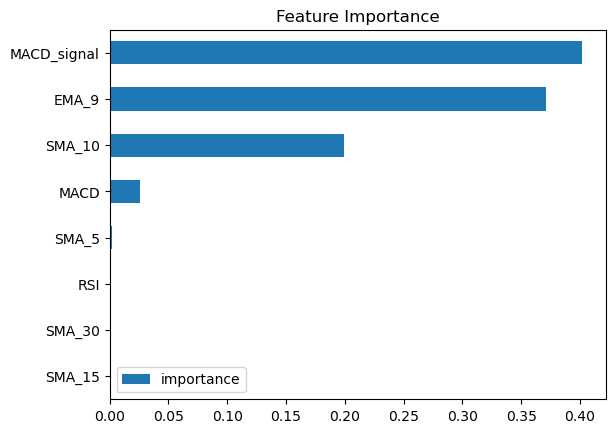

In [186]:
show_feature_importance(model_30)
predictions = pd.DataFrame(to_predict_df)
predictions['Close'] = y_pred_30
plot_predictions(predictions, truth_df)

### Predicted values CSV

In [ ]:
output_df = pd.read_csv(os.path.join(os.getcwd(), '../', 'data','to_predict.csv'), parse_dates=['Exchange Date'])
output_df['Close'] = y_pred_30
output_df.to_csv((os.getcwd(), '../', 'data','xgboost_output.csv'), index=False)